<a href="https://colab.research.google.com/github/casblood18/Painting-3D-Game-Objects-Using-Generative-AI/blob/main/Rendered%20Images%20With%20Generated%20Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Dependencies


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
# ==================
# install Diffusers
# ==================
!source '/content/drive/My Drive/dev/colab_env/bin/activate'
!pip install accelerate
!pip install "git+https://github.com/huggingface/diffusers"

# ==================
# install OpenCV
# ==================
!pip install opencv-python

In [ ]:
import cv2
import pytorch3d
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, save_obj

# Week 4 Dependencies
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesUV,
    TexturesVertex
)

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

###Project


In [5]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction.
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow.
R, T = look_at_view_transform(2.7, 0, 225)
side_view_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

R, T = look_at_view_transform(2.7, 0, 180)
front_view_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of
# the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the
# -z direction.
lights = PointLights(device=device, location=[[90.0, 0.0, 0.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will
# interpolate the texture uv coordinates for each vertex, sample from a texture image and
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=side_view_cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=side_view_cameras,
        lights=lights
    )
)

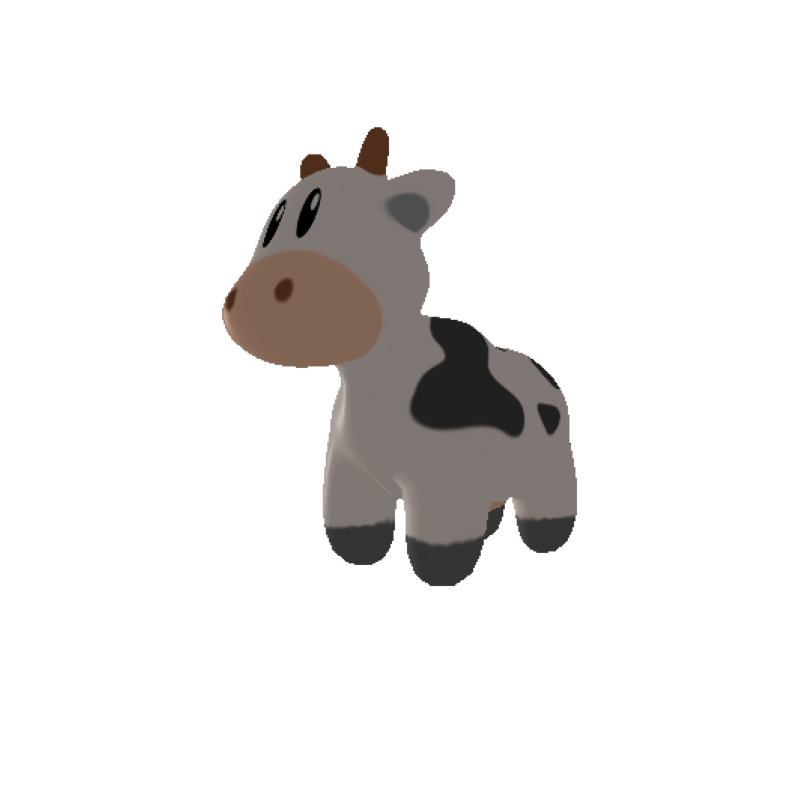

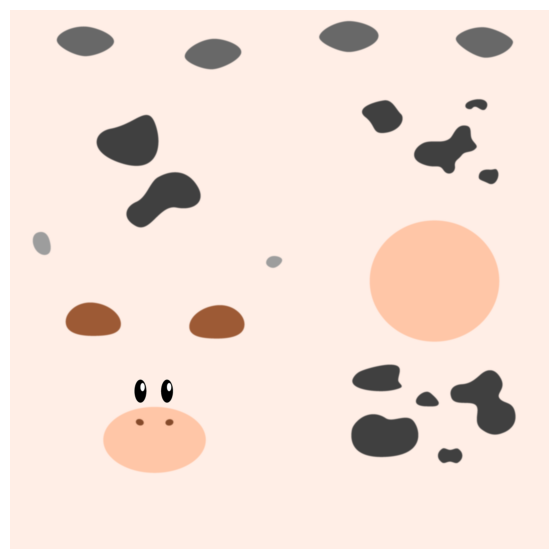

In [6]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
obj_filename = "/content/drive/MyDrive/Colab Notebooks/Project_1/cow/cow.obj"

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# Render the obj as is
rendered_image = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(rendered_image[0, ..., :3].cpu().numpy())
plt.axis("off");

# Visualize the texture map
plt.figure(figsize=(7,7))
texture_image=mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

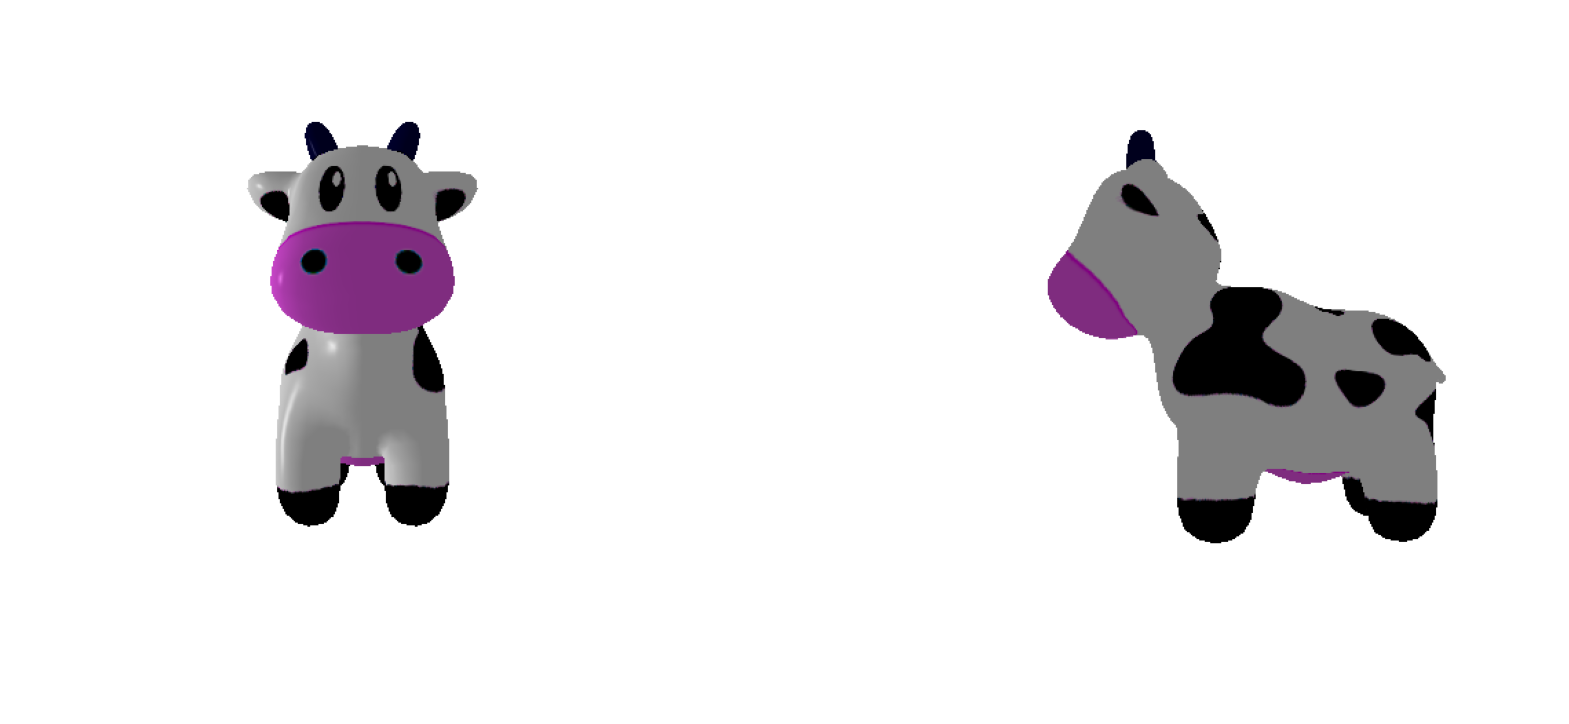

In [ ]:
# Week 2: Pytorch3D Textures and Rendering
verts, face, aux = load_obj("/content/drive/MyDrive/Colab Notebooks/Project_1/cow/cow.obj", load_textures=True)
faces_uvs = face.textures_idx.to(device)
verts_uvs = aux.verts_uvs.to(device)

# Load pink textured cow image
im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Project_1/cow/cow_texture_pink.png")
im = im.astype(np.float32)
im = torch.from_numpy(im/255).to(device)

pink_images = []

# Front view of pink textured cow
renderer.rasterizer.cameras = front_view_cameras
renderer.shader.cameras = front_view_cameras

# Change the texture map to the pink cow
mesh.textures = TexturesUV(maps=[im], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])
rendered_image = renderer(mesh)
pink_images.append(rendered_image[0, ..., :3].cpu().numpy())

# Side view of pink textured cow
renderer.rasterizer.cameras = side_view_cameras
renderer.shader.cameras = side_view_cameras

# Render with new camera position
rendered_image = renderer(mesh)
pink_images.append(rendered_image[0, ..., :3].cpu().numpy())

# Plot the rendered images
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i, image in enumerate(pink_images):
    axes[i].imshow(image)
    axes[i].axis("off")
plt.show()

In [ ]:
# Week 3: Generate new texture images using [SD] vs [ControlNet]
load_images = []

# File paths of the ControlNet images with Canny model
image_paths = [
    "/content/drive/MyDrive/Colab Notebooks/Project_1/cow/cow_texture_dark.png",
    "/content/drive/MyDrive/Colab Notebooks/Project_1/cow/blue.png",
    "/content/drive/MyDrive/Colab Notebooks/Project_1/cow/cow_texture_candy.png",
    "/content/drive/MyDrive/Colab Notebooks/Project_1/cow/cow_kingdom.png"
]
LOAD_IMAGES_SIZE = len(image_paths)

# Load the images, normalize them, and add them to the list
for image_path in image_paths:
    image = cv2.imread(image_path)
    image = image.astype(np.float32)
    image = torch.from_numpy(image/255).to(device)
    load_images.append(image)

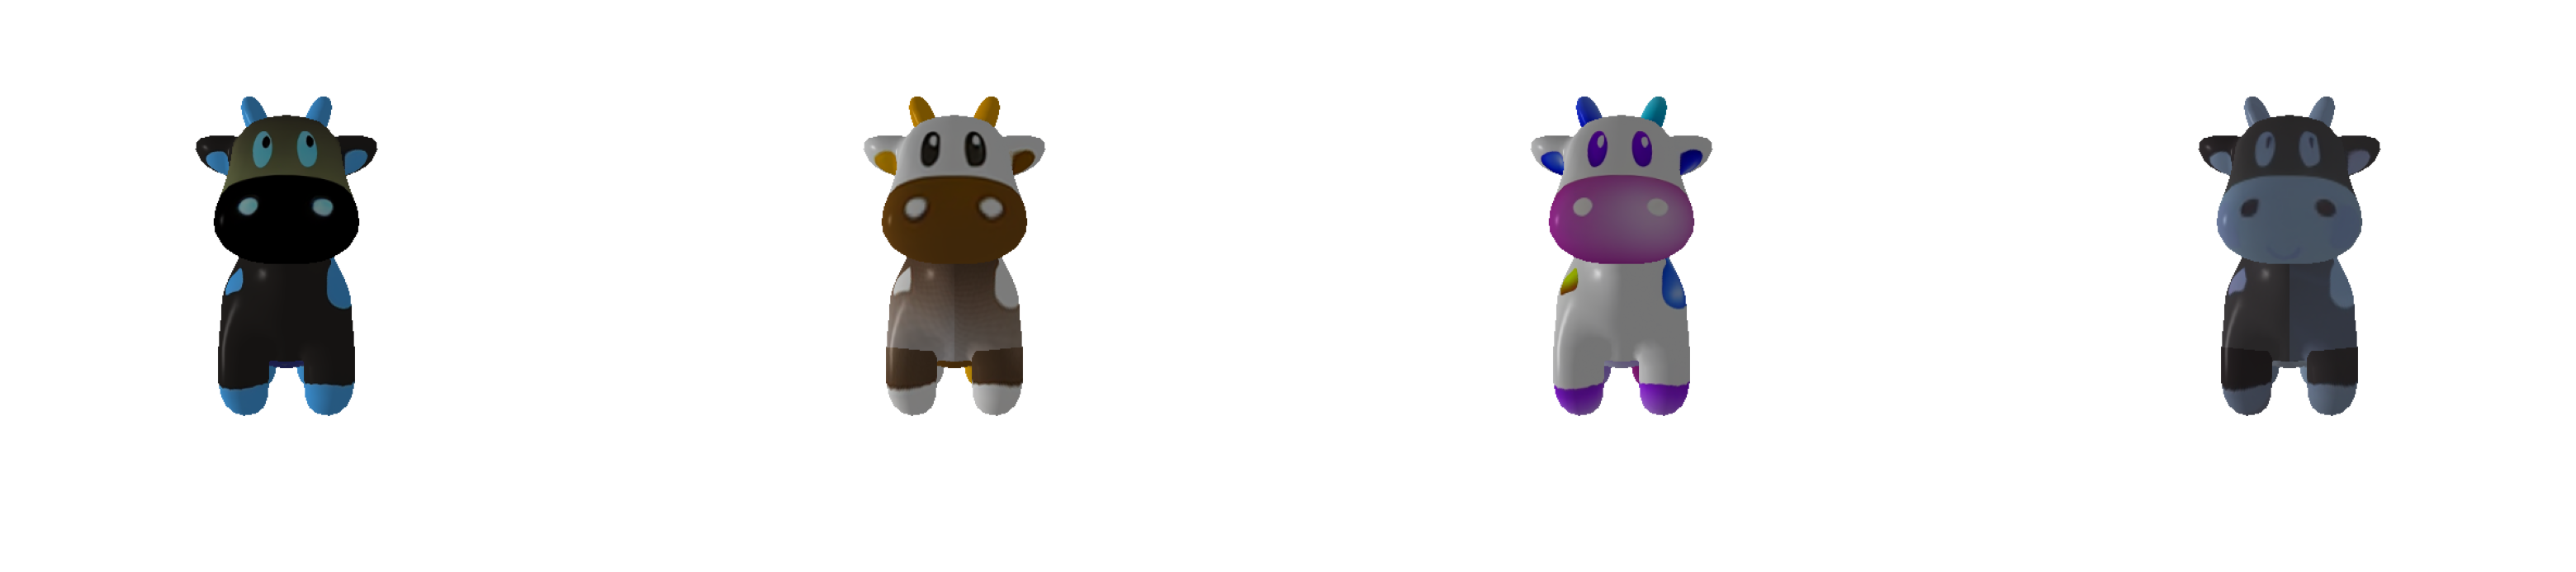

In [ ]:
# Setup camera angle to view the front of obj
renderer.rasterizer.cameras = front_view_cameras
renderer.shader.cameras = front_view_cameras
images = []

# Render each image and append it to the images list
for i in range(LOAD_IMAGES_SIZE):
  mesh.textures = TexturesUV(maps=[load_images[i]], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])
  rendered_image = renderer(mesh)
  images.append(rendered_image[0, ..., :3].cpu().numpy())

# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(40, 10))
for i, image in enumerate(images):
  axes[i].imshow(image)
  axes[i].axis("off")
plt.show()